In [58]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [59]:
train_raw = pd.read_csv('VSTrain.dt', header=None)
train_raw.rename(columns={train_raw.columns[-1]: 'class'}, inplace=True)
train_raw.astype({'class': int}, errors='raise') 

test_raw = pd.read_csv('VSTest.dt', header=None)
test_raw.rename(columns={test_raw.columns[-1]: 'class'}, inplace=True)
test_raw.astype({'class': int}, errors='raise');

## 2.1 Data understanding and preprocessing
Remove all data points belonging to classes with less than 65 training examples. Report which classes and how many training and test examples remain.

In [60]:
vcs = train_raw['class'].value_counts()
classes = set(vcs[vcs >= 65].index)
train = train_raw.loc[train_raw['class'].isin(classes), :]
test = test_raw.loc[test_raw['class'].isin(classes), :]

vcs_norm = train_raw['class'].value_counts(normalize=True)
print("Classes with frequency\n", vcs_norm[list(classes)])
print()
print("Remaining train classes with counts:\n", train['class'].value_counts())
print()
print("Remaining test classes with counts:\n", test['class'].value_counts())

Classes with frequency
 0     0.088197
3     0.124514
22    0.106355
23    0.088197
Name: class, dtype: float64

Remaining train classes with counts:
 3     96
22    82
0     68
23    68
Name: class, dtype: int64

Remaining test classes with counts:
 3     95
22    87
23    77
0     76
Name: class, dtype: int64


Normalized data

In [61]:

x_train = train.loc[:, train.columns[:-1]]
y_train = train.loc[:, ['class']]

x_test = test.loc[:, test.columns[:-1]]
y_test = test.loc[:, ['class']]

means = x_train.mean()
norm_train = (x_train - means) / x_train.std()
norm_test = (x_test - means) / x_train.std()

## 2.2 PCA

In [62]:
from sklearn.decomposition import PCA

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [63]:
pca = PCA(n_components=2)
pca.fit(norm_train.T)
principal_components = pca.fit_transform(norm_train)

pca_df = pd.DataFrame(data = principal_components, columns=['pca1', 'pca2'])
pca_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
final_df = pd.concat([pca_df, y_train], axis=1)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.29139703 0.14090161]


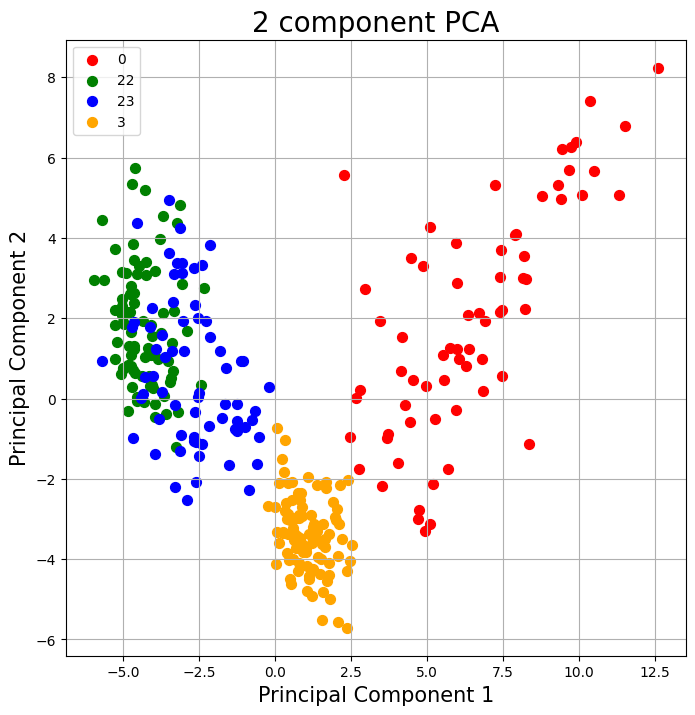

In [64]:

colors = ['r', 'g', 'b', 'orange']
def plot(df, colors):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)

    targets = y_train['class'].unique()
    for target, color in zip(targets, colors):
        indicesToKeep = df['class'] == target
        ax.scatter(df.loc[indicesToKeep, 'pca1']
                , df.loc[indicesToKeep, 'pca2']
                , c = color
                , s = 50)
    ax.legend(targets)
    ax.grid()

    return fig, ax

plot(final_df, colors)
plt.savefig("images/pca.png");

## 2.3 Clustering
4-means and 4-means++

In [65]:
from sklearn.cluster import KMeans

4-means

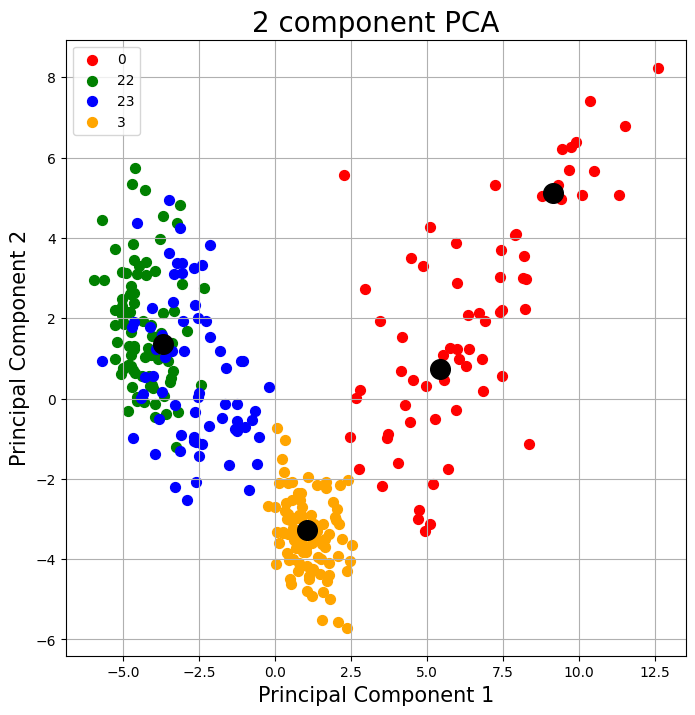

In [66]:
from sklearn.cluster import KMeans
clusters = 4
means4 = KMeans(clusters, init='random', max_iter=5 n_init=1)
means4.fit(norm_train)

fig, ax = plot(final_df, colors)
means4_centers = np.dot(means4.cluster_centers_, pca.components_.T)
x = means4_centers[:, 0]
y = means4_centers[:, 1]
ax.scatter(x, y, c='black', s=200)
plt.savefig("images/4means.png");

4-means++

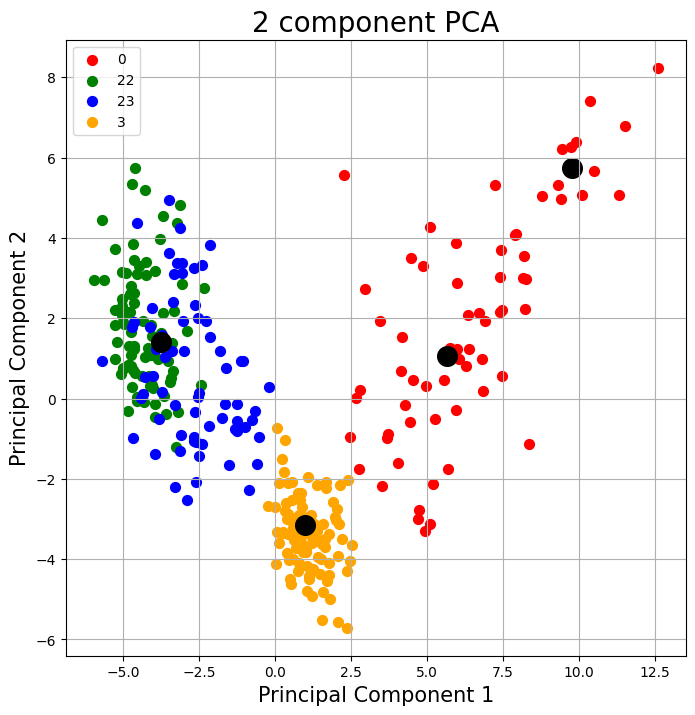

In [67]:
means4_pp = KMeans(clusters, init='k-means++')
means4_pp.fit(norm_train)

fig, ax = plot(final_df, colors)
means4_pp_centers = np.dot(means4_pp.cluster_centers_, pca.components_.T)
x = means4_pp_centers[:, 0]
y = means4_pp_centers[:, 1]
ax.scatter(x, y, c='black', s=200)
plt.savefig("images/4means++.png");